# Overview

We want to operate a car in the simulated racing environment [Car Racing](https://gymnasium.farama.org/environments/box2d/car_racing/).

There are two steps. First is pretraining, which involves preprocessing the data and loading it for semi-supervised learning. Second is reinforcement learning which we used the pretrained encoder to represent the input as a latent image.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

SUBDIR = "renders"
SUPERDIR = "/content/drive/MyDrive/data"
np.random.seed(42)              # lucky number 42
torch.manual_seed(42)           # don't fail me now

### Action Space

$$ \mathbb R ^ {3} $$

Actions are continuous 3-vector:

- 0: steering, -1 is full left, +1 is full right

- 1: gas

- 2: braking

### Observation Space

$$(256)^{96 \times 96}$$

A top-down 96x96 RGB image of the car and race track


### Data Preprocessing

We have over 2,000 screen captures from the Car Racing simulator.

Each is the same 96x96 colored resolution as the model input.
They also have labels: left, right or straight for the direction of the car.
For example, see 3 samples:

LEFT: ![LEFT](./images/frame-1002-left.png)
STRAIGHT: ![STRAIGHT](./images/frame-100-straight.png)
RIGHT: ![RIGHT](./images/frame-207-right.png)


In [4]:
def horz_mirror(data_dir):
    """
    yield a generator of filenames that are left or right turns
    """
    for fname in os.listdir(data_dir):
        if "left" in fname or "right" in fname:
            yield fname

def flip_img(img_arr, above=84):
    """
    flip an image horizontally above the line at above
    """
    top = img_arr[:above, ::-1]
    bot = img_arr[above:, :]
    return np.concatenate([top, bot], axis=0)

def make_horz_data(superdir, subdir):
    """
    does the data transforamation for all the images in superdir/subdir
    puts new images in superdir/horz_subdir/..., where left is switched to right
    in the filename and vice versa
    """
    for fname in os.listdir(os.sep.join([superdir, subdir])):
        if "straight" in fname:
            # sepr = fname.index("straight")
            # num = fname[len("frame-") : sepr-1]
            # new_direction = direction = "straight"
            continue
        else:
            sepr = fname.index("left") if "left" in fname else fname.index("right")
            num, direction = fname[len("frame-") : sepr-1], fname[sepr : -4]
            new_direction = "right" if direction=="left" else "left"
        img_arr = plt.imread(os.sep.join([superdir, subdir, fname]))
        new_arr = flip_img(img_arr)
        new_name = "-".join(("frame",num, new_direction + ".png"))
        plt.imsave(arr=new_arr, fname=os.sep.join((superdir, "horz_"+subdir,new_name)))
        yield new_name


### Transformation

We can cut off the top part (above the toolbar) and flip that horizontally. This is valid since the car always points north. It effectively doubles the number of samples.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
images_path = '/content/drive/MyDrive/images'
data_path = '/content/drive/MyDrive/data'

In [7]:
import matplotlib.pyplot as plt
img_path = '/content/drive/MyDrive/images/frame-1002-left.png'
img_arr = plt.imread(img_path)

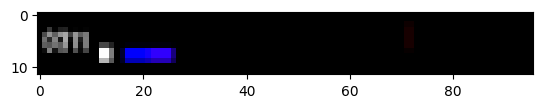

In [8]:
#img_arr = plt.imread("./images/frame-1002-left.png")
display(plt.imshow(img_arr[84:, :]))

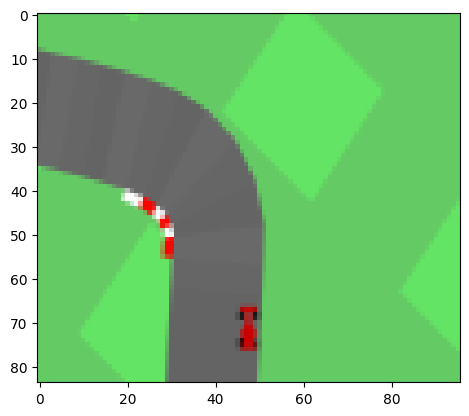

In [9]:
display(plt.imshow(img_arr[:84, :]))

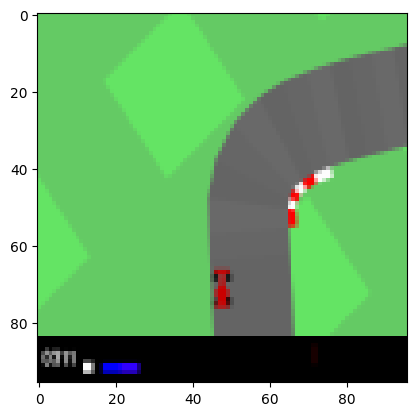

In [10]:
plt.imshow(flip_img(img_arr))

In [11]:
if "horz_" + SUBDIR in os.listdir(SUPERDIR):
    print("already have horizontal data directory")
else:
    os.mkdir(os.sep.join((SUPERDIR, "horz_"+SUBDIR)))
    for i, fname in enumerate(make_horz_data(SUPERDIR, SUBDIR)):
        print(f"Added new image[ {fname:^20s} ] # {i}")

already have horizontal data directory


### Dataloader + Dataset

Lastly we should batch the images and load them randomly for pretraining.

They are labelled, but the labels don't matter right now. Later we can use the labels to generate an *average representation* of left, right and stright roads.

We can use this for XAI.

In [12]:
class CarRacingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.filenames = []
        for subdir in os.listdir(root_dir):
            curdir = os.sep.join((root_dir, subdir))
            self.filenames += [os.sep.join((subdir,fname)) for fname in os.listdir(curdir)
                               if fname.endswith('.png')]
            self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        name = img_path.split("/")[-1]
        if "left" in name:
            label = 0
        elif "right" in name:
            label = 1
        else:
            label = 2
        return image, label

In [13]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),  # scales to [0,1]
    # Optionally add normalization here if needed
])

# Define directories (update these paths as needed)
DATA_DIR = os.path.join("/content/drive/MyDrive/data")
BATCH_SIZE = 64
LABELS = ["Left", "Right", "Straight"]

# Create DataLoader
dataset = CarRacingDataset(root_dir=DATA_DIR, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size  # ensures all samples are used

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Architecture

We use a variational autoencoder to learn low-dimensional representations for the state space.

This is pretraining: the objective is to simply reconstruct the original input image after passing through a low-D bottleneck.

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            # Input: [3, 96, 96]
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # -> [32, 48, 48]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [32, 24, 24]

            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # -> [32, 12, 12]
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> [64, 12, 12]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),  # -> [64, 6, 6]

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> [128, 3, 3]
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.fc_enc = nn.Linear(128 * 3 * 3, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, 256)
        self.fc_dec2 = nn.Linear(256, 128 * 3 * 3)
        self.decoder = nn.Sequential(
            # Start with tensor of shape [128, 3, 3]
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [128, 6, 6]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [64, 12, 12]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [32, 24, 24]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [32, 48, 48]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [16, 96, 96]
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)  # -> [3, 96, 96]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        h = torch.relu(self.fc_enc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc_dec1(z))
        h = torch.relu(self.fc_dec2(h))
        h = h.view(h.size(0), 128, 3, 3)
        x_recon = self.decoder(h)
        return torch.sigmoid(x_recon)  # assume image pixel range [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [15]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [16]:
def display_samples(original, recon, labels=None, epoch=None, title=None):
    """Display a few original and reconstructed images side by side."""
    original = original.cpu().numpy()
    recon = recon.cpu().numpy()
    n = min(6, original.shape[0])
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')

        if labels is not None and i < len(labels):
            axes[1, i].set_title(LABELS[labels[i]], fontsize=10)

        axes[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
        axes[1, i].axis('off')
    if epoch is not None:
        plt.suptitle(f"Epoch {epoch} - Top: Originals, Bottom: Reconstructions")
    elif title is not None:
        plt.suptitle(f"{title} Samples")
    plt.show()

In [17]:
def train_epoch(model, dataloader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)}] Loss: {loss.item()/len(data):.4f}", end="\r")
    avg_loss = train_loss / len(dataloader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")
    return avg_loss

In [18]:
def validate_epoch(model, dataloader, device, epoch, display=True):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    avg_loss = val_loss / len(dataloader.dataset)
    print(f"====> Validation loss: {avg_loss:.4f}")
    # Show a random batch of originals and reconstructions
    if display:
        (data, label)  = [i.to(device) for i in next(iter(dataloader))]
        label = [l.item() for l in label]
        recon, _, _ = model(data)
        display_samples(data.detach(), recon.detach(), label, epoch)
    return avg_loss

In [19]:
def test_model(model, dataloader, device, display=True):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    avg_loss = test_loss / len(dataloader.dataset)
    print(f"====> Test loss: {avg_loss:.4f}")
    # Display reconstructions from a batch of test images
    (data, label)  = [i.to(device) for i in next(iter(dataloader))]
    label = [l.item() for l in label]
    recon, _, _ = model(data)
    display_samples(data.detach(), recon.detach(), label, title="Test")
    return avg_loss

====> Epoch: 1 Average loss: 18564.9128
====> Validation loss: 17703.3310


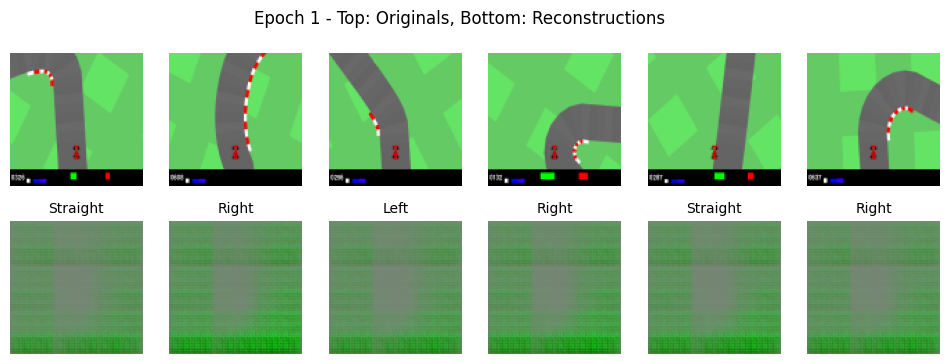

====> Epoch: 2 Average loss: 16466.2528
====> Validation loss: 15966.1253
====> Epoch: 3 Average loss: 15885.5733
====> Validation loss: 15793.6872
====> Epoch: 4 Average loss: 15743.3900
====> Validation loss: 15667.7901
====> Epoch: 5 Average loss: 15636.6913
====> Validation loss: 15585.9755
====> Epoch: 6 Average loss: 15571.2085
====> Validation loss: 15544.3362
====> Epoch: 7 Average loss: 15530.9316
====> Validation loss: 15504.8953
====> Epoch: 8 Average loss: 15495.3279
====> Validation loss: 15471.1021
====> Epoch: 9 Average loss: 15457.7064
====> Validation loss: 15437.1838
====> Epoch: 10 Average loss: 15422.0401
====> Validation loss: 15407.9412
====> Epoch: 11 Average loss: 15400.2143
====> Validation loss: 15391.9958


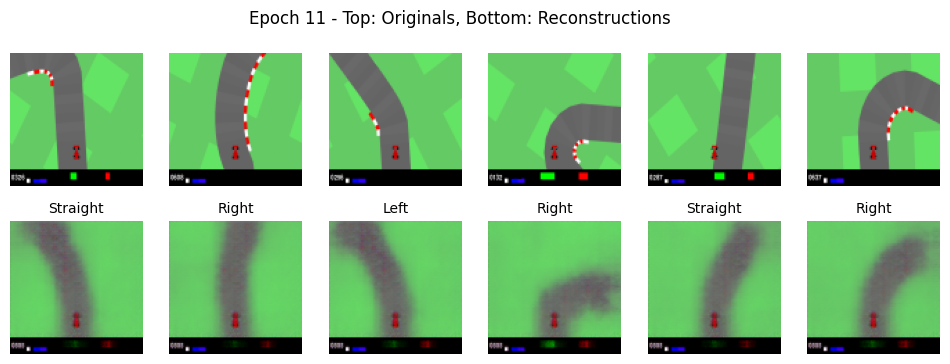

====> Epoch: 12 Average loss: 15385.3164
====> Validation loss: 15381.0675
====> Epoch: 13 Average loss: 15374.4618
====> Validation loss: 15374.3871
====> Epoch: 14 Average loss: 15363.3630
====> Validation loss: 15360.7410
====> Epoch: 15 Average loss: 15356.5044
====> Validation loss: 15357.6450
====> Epoch: 16 Average loss: 15350.1867
====> Validation loss: 15356.7840
====> Epoch: 17 Average loss: 15347.4509
====> Validation loss: 15344.5079
====> Epoch: 18 Average loss: 15340.9479
====> Validation loss: 15340.1928
====> Epoch: 19 Average loss: 15336.0501
====> Validation loss: 15336.1551
====> Epoch: 20 Average loss: 15332.0194
====> Validation loss: 15337.2809
Saved model weights to pre_model_weights/20/vae.pth
====> Epoch: 21 Average loss: 15330.2153
====> Validation loss: 15328.7136


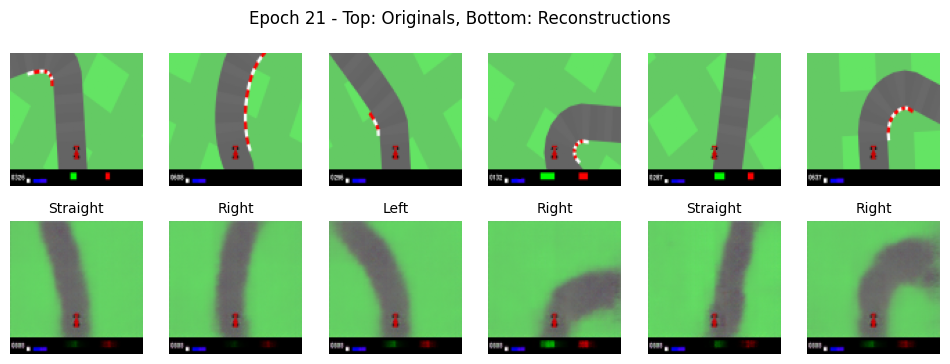

====> Epoch: 22 Average loss: 15324.7957
====> Validation loss: 15328.1511
====> Epoch: 23 Average loss: 15324.1962
====> Validation loss: 15330.2603
====> Epoch: 24 Average loss: 15321.7872
====> Validation loss: 15324.4422
====> Epoch: 25 Average loss: 15318.7356
====> Validation loss: 15323.4924
====> Epoch: 26 Average loss: 15315.7144
====> Validation loss: 15317.8816
====> Epoch: 27 Average loss: 15314.0489
====> Validation loss: 15318.6379
====> Epoch: 28 Average loss: 15311.1731
====> Validation loss: 15314.3054
====> Epoch: 29 Average loss: 15308.8328
====> Validation loss: 15311.7619
====> Epoch: 30 Average loss: 15308.7288
====> Validation loss: 15309.5327
====> Epoch: 31 Average loss: 15307.1930
====> Validation loss: 15307.1255


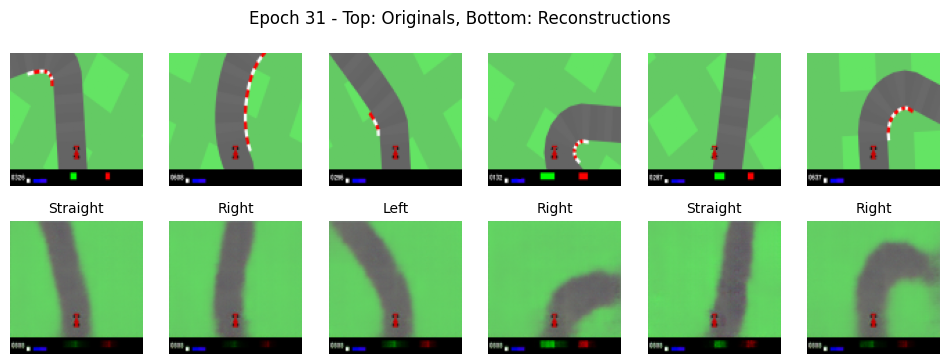

====> Epoch: 32 Average loss: 15303.6130
====> Validation loss: 15308.6326
====> Epoch: 33 Average loss: 15305.2720
====> Validation loss: 15307.5055
====> Epoch: 34 Average loss: 15302.3131
====> Validation loss: 15305.7998
====> Epoch: 35 Average loss: 15300.9244
====> Validation loss: 15305.1920
====> Epoch: 36 Average loss: 15300.3681
====> Validation loss: 15301.7803
====> Epoch: 37 Average loss: 15298.9708
====> Validation loss: 15303.7587
====> Epoch: 38 Average loss: 15298.5819
====> Validation loss: 15299.7703
====> Epoch: 39 Average loss: 15296.8832
====> Validation loss: 15304.8573
====> Epoch: 40 Average loss: 15297.6705
====> Validation loss: 15303.3916
Saved model weights to pre_model_weights/40/vae.pth
====> Epoch: 41 Average loss: 15296.1788
====> Validation loss: 15301.7197


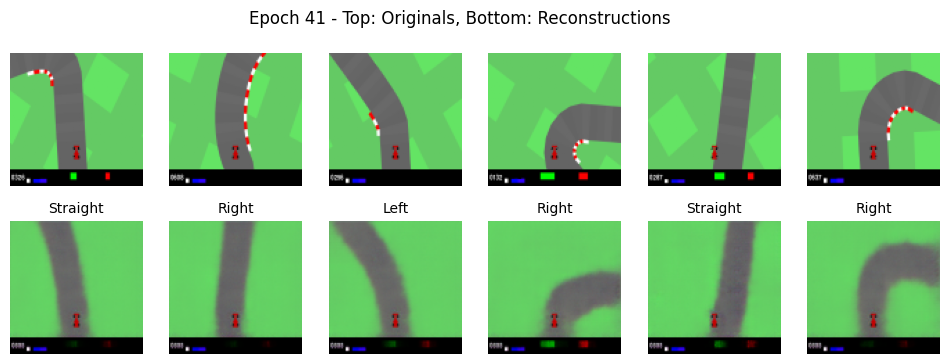

====> Epoch: 42 Average loss: 15297.1914
====> Validation loss: 15303.1400
====> Epoch: 43 Average loss: 15297.6824
====> Validation loss: 15299.7128
====> Epoch: 44 Average loss: 15294.7589
====> Validation loss: 15297.1134
====> Epoch: 45 Average loss: 15293.6837
====> Validation loss: 15297.0003
====> Epoch: 46 Average loss: 15292.3858
====> Validation loss: 15297.1055
====> Epoch: 47 Average loss: 15292.3467
====> Validation loss: 15302.9391
====> Epoch: 48 Average loss: 15292.0909
====> Validation loss: 15302.3236
====> Epoch: 49 Average loss: 15290.9521
====> Validation loss: 15299.8165
====> Epoch: 50 Average loss: 15292.4197
====> Validation loss: 15301.7120
====> Epoch: 51 Average loss: 15291.5102
====> Validation loss: 15299.5224


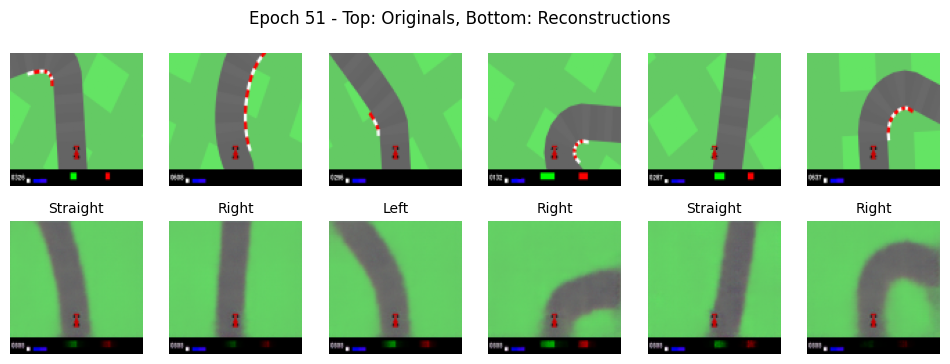

====> Epoch: 52 Average loss: 15289.5930
====> Validation loss: 15297.3220
====> Epoch: 53 Average loss: 15289.5694
====> Validation loss: 15297.4858
====> Epoch: 54 Average loss: 15287.2412
====> Validation loss: 15296.9277
====> Epoch: 55 Average loss: 15289.6713
====> Validation loss: 15297.6788
====> Epoch: 56 Average loss: 15287.4177
====> Validation loss: 15296.0767
====> Epoch: 57 Average loss: 15286.5822
====> Validation loss: 15297.3940
====> Epoch: 58 Average loss: 15287.8281
====> Validation loss: 15296.4979
====> Epoch: 59 Average loss: 15288.3875
====> Validation loss: 15294.5237
====> Epoch: 60 Average loss: 15286.9343
====> Validation loss: 15295.4222
Saved model weights to pre_model_weights/60/vae.pth
====> Epoch: 61 Average loss: 15285.3067
====> Validation loss: 15297.3948


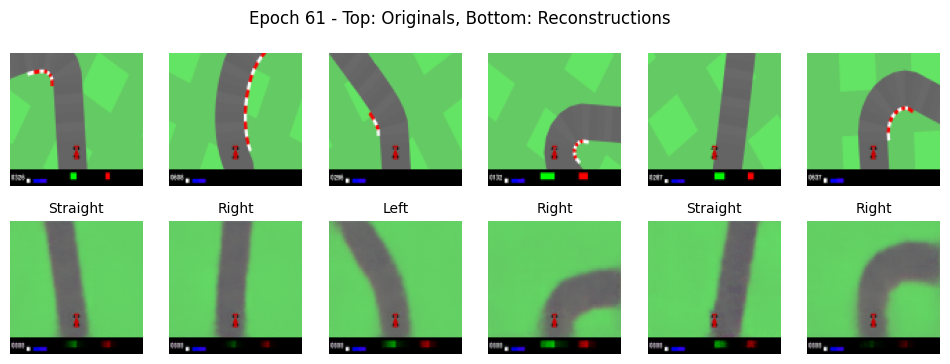

====> Epoch: 62 Average loss: 15286.6002
====> Validation loss: 15301.3544
====> Epoch: 63 Average loss: 15287.3209
====> Validation loss: 15297.3083
====> Epoch: 64 Average loss: 15285.4617
====> Validation loss: 15293.3755
====> Epoch: 65 Average loss: 15284.7202
====> Validation loss: 15293.2935
====> Epoch: 66 Average loss: 15284.4801
====> Validation loss: 15297.0485
====> Epoch: 67 Average loss: 15283.0037
====> Validation loss: 15293.3755
====> Epoch: 68 Average loss: 15282.7467
====> Validation loss: 15293.6711
====> Epoch: 69 Average loss: 15282.1521
====> Validation loss: 15294.0873
====> Epoch: 70 Average loss: 15282.7782
====> Validation loss: 15294.1667
====> Epoch: 71 Average loss: 15281.1640
====> Validation loss: 15294.7297


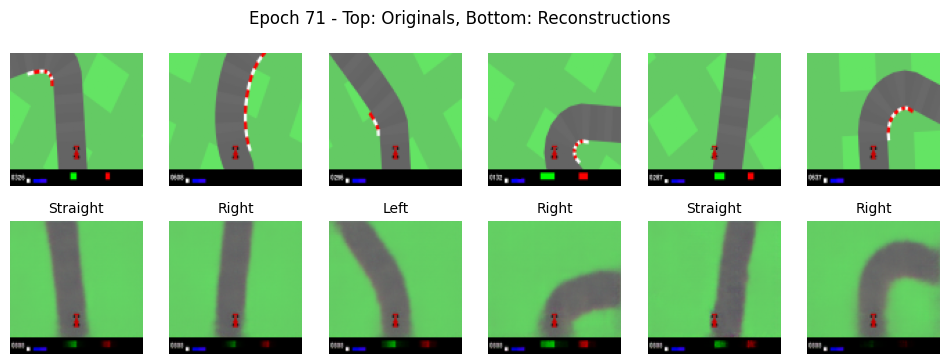

====> Epoch: 72 Average loss: 15282.6498
====> Validation loss: 15294.8004
====> Epoch: 73 Average loss: 15282.9927
====> Validation loss: 15295.3935
====> Epoch: 74 Average loss: 15281.0355
====> Validation loss: 15294.4942
====> Epoch: 75 Average loss: 15280.0905
====> Validation loss: 15293.6559
====> Epoch: 76 Average loss: 15281.1601
====> Validation loss: 15295.1263
====> Epoch: 77 Average loss: 15281.1596
====> Validation loss: 15290.7168
====> Epoch: 78 Average loss: 15279.8285
====> Validation loss: 15293.0364
====> Epoch: 79 Average loss: 15279.6972
====> Validation loss: 15292.2318
====> Epoch: 80 Average loss: 15280.2946
====> Validation loss: 15291.0134
Saved model weights to pre_model_weights/80/vae.pth
====> Epoch: 81 Average loss: 15279.6682
====> Validation loss: 15291.9109


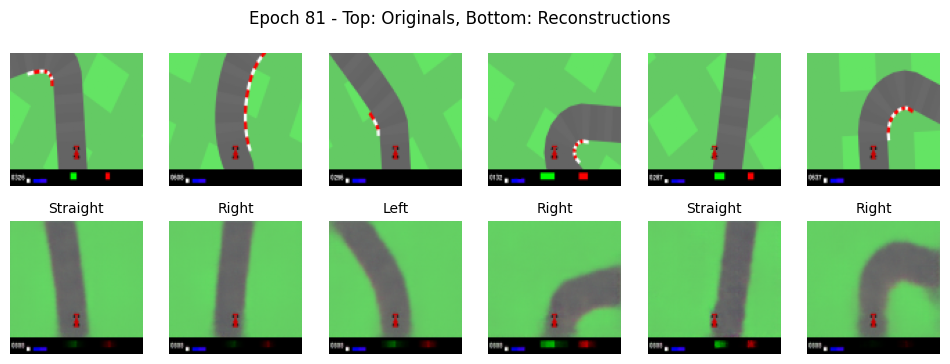

====> Epoch: 82 Average loss: 15279.4770
====> Validation loss: 15292.3763
====> Epoch: 83 Average loss: 15277.6016
====> Validation loss: 15292.7969
====> Epoch: 84 Average loss: 15279.3356
====> Validation loss: 15293.1414
====> Epoch: 85 Average loss: 15280.4857
====> Validation loss: 15293.2110
====> Epoch: 86 Average loss: 15277.2662
====> Validation loss: 15290.0198
====> Epoch: 87 Average loss: 15276.7047
====> Validation loss: 15291.0303
====> Epoch: 88 Average loss: 15276.3236
====> Validation loss: 15295.0796
====> Epoch: 89 Average loss: 15276.9387
====> Validation loss: 15289.8742
====> Epoch: 90 Average loss: 15277.9386
====> Validation loss: 15294.6854
====> Epoch: 91 Average loss: 15279.8778
====> Validation loss: 15291.1522


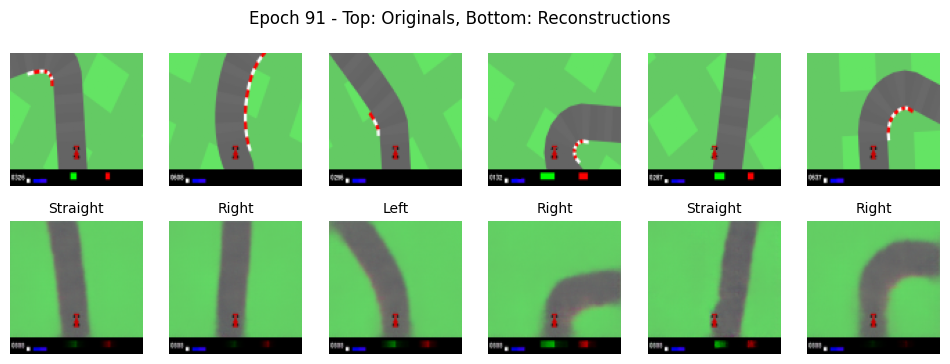

====> Epoch: 92 Average loss: 15277.7090
====> Validation loss: 15294.2165
====> Epoch: 93 Average loss: 15277.2338
====> Validation loss: 15295.3613
====> Epoch: 94 Average loss: 15277.0679
====> Validation loss: 15295.9056
====> Epoch: 95 Average loss: 15276.1616
====> Validation loss: 15293.7592
====> Epoch: 96 Average loss: 15277.3246
====> Validation loss: 15290.5380
====> Epoch: 97 Average loss: 15274.9697
====> Validation loss: 15290.6139
====> Epoch: 98 Average loss: 15274.5334
====> Validation loss: 15295.2711
====> Epoch: 99 Average loss: 15276.0593
====> Validation loss: 15289.1756
====> Epoch: 100 Average loss: 15274.1543
====> Validation loss: 15290.9172
Saved model weights to pre_model_weights/100/vae.pth
====> Epoch: 101 Average loss: 15274.4851
====> Validation loss: 15289.7534


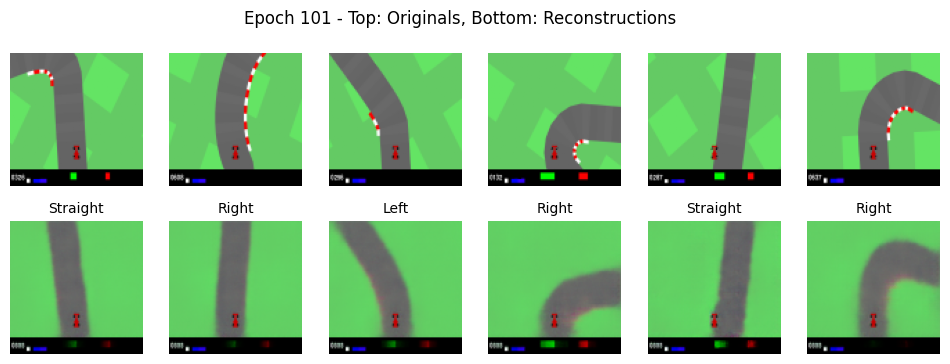

====> Epoch: 102 Average loss: 15274.6860
====> Validation loss: 15292.8985
====> Epoch: 103 Average loss: 15272.4529
====> Validation loss: 15288.2439
====> Epoch: 104 Average loss: 15273.0371
====> Validation loss: 15289.7703
====> Epoch: 105 Average loss: 15272.6357
====> Validation loss: 15288.4001
====> Epoch: 106 Average loss: 15274.0430
====> Validation loss: 15293.4939
====> Epoch: 107 Average loss: 15274.2281
====> Validation loss: 15292.4784
====> Epoch: 108 Average loss: 15272.7463
====> Validation loss: 15288.1638
====> Epoch: 109 Average loss: 15273.1697
====> Validation loss: 15288.9164
====> Epoch: 110 Average loss: 15273.6001
====> Validation loss: 15292.2619
====> Epoch: 111 Average loss: 15272.2435
====> Validation loss: 15289.3507


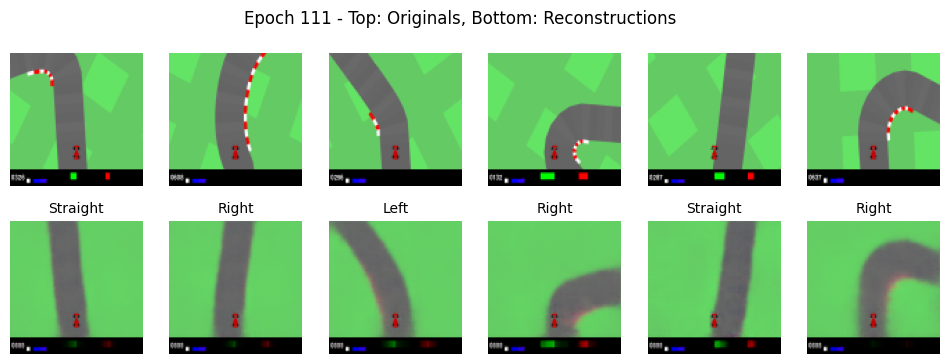

====> Epoch: 112 Average loss: 15272.7545
====> Validation loss: 15291.5008
====> Epoch: 113 Average loss: 15272.5854
====> Validation loss: 15290.1229
====> Epoch: 114 Average loss: 15271.2917
====> Validation loss: 15288.0641
====> Epoch: 115 Average loss: 15271.2171
====> Validation loss: 15287.9602
====> Epoch: 116 Average loss: 15271.5121
====> Validation loss: 15291.0127
====> Epoch: 117 Average loss: 15270.9850
====> Validation loss: 15290.5696
====> Epoch: 118 Average loss: 15269.6245
====> Validation loss: 15286.9219
====> Epoch: 119 Average loss: 15269.0422
====> Validation loss: 15288.3790
====> Epoch: 120 Average loss: 15268.8719
====> Validation loss: 15285.2587
Saved model weights to pre_model_weights/120/vae.pth
====> Epoch: 121 Average loss: 15271.3269
====> Validation loss: 15288.5082


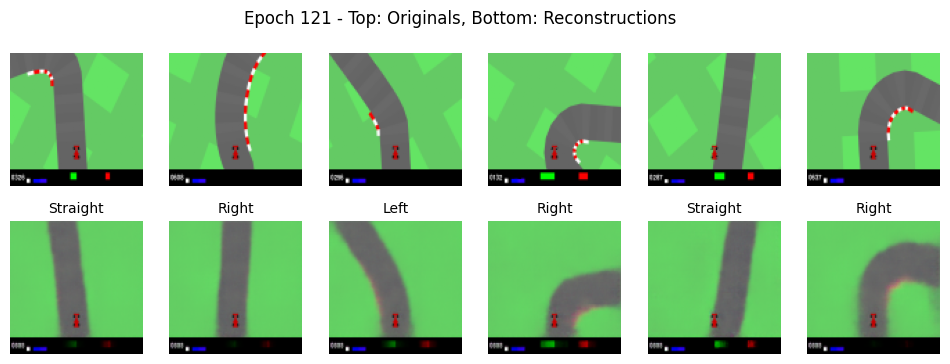

====> Epoch: 122 Average loss: 15273.1235
====> Validation loss: 15288.6946
====> Epoch: 123 Average loss: 15268.4215
====> Validation loss: 15290.5280
====> Epoch: 124 Average loss: 15270.4499
====> Validation loss: 15304.4370
====> Epoch: 125 Average loss: 15278.2052
====> Validation loss: 15292.7964
====> Epoch: 126 Average loss: 15272.3651
====> Validation loss: 15292.6181
====> Epoch: 127 Average loss: 15270.1723
====> Validation loss: 15291.4889
====> Epoch: 128 Average loss: 15270.4656
====> Validation loss: 15288.3998
====> Epoch: 129 Average loss: 15268.2555
====> Validation loss: 15289.3046
====> Epoch: 130 Average loss: 15268.3560
====> Validation loss: 15288.4088
====> Epoch: 131 Average loss: 15267.5004
====> Validation loss: 15287.7658


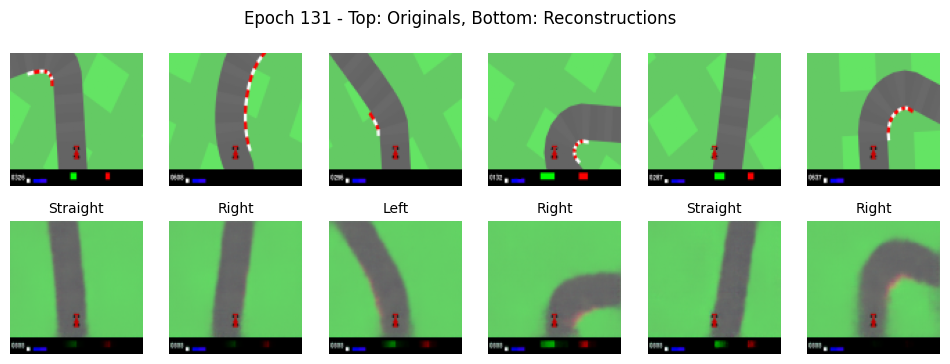

====> Epoch: 132 Average loss: 15268.5185
====> Validation loss: 15285.8753
====> Epoch: 133 Average loss: 15268.3440
====> Validation loss: 15287.7592
====> Epoch: 134 Average loss: 15267.0997
====> Validation loss: 15287.2954
====> Epoch: 135 Average loss: 15266.3705
====> Validation loss: 15288.4665
====> Epoch: 136 Average loss: 15267.7483
====> Validation loss: 15288.7484
====> Epoch: 137 Average loss: 15268.1306
====> Validation loss: 15287.9451
====> Epoch: 138 Average loss: 15273.9907
====> Validation loss: 15289.3349
====> Epoch: 139 Average loss: 15268.9317
====> Validation loss: 15291.2133
====> Epoch: 140 Average loss: 15266.2619
====> Validation loss: 15288.4106
Saved model weights to pre_model_weights/140/vae.pth
====> Epoch: 141 Average loss: 15266.6098
====> Validation loss: 15294.2505


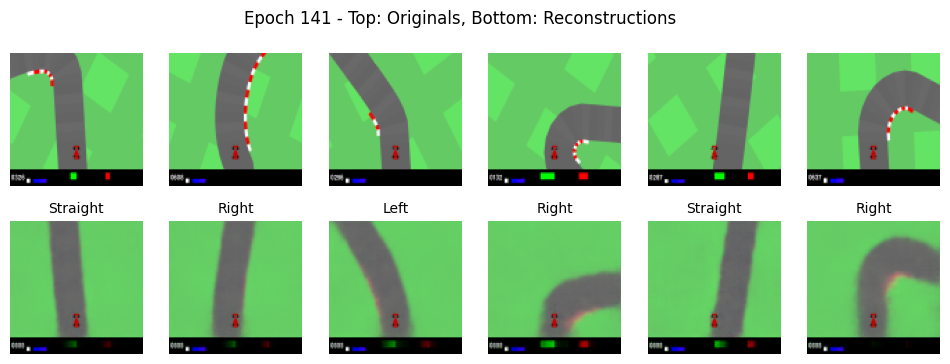

====> Epoch: 142 Average loss: 15269.1504
====> Validation loss: 15287.4873
====> Epoch: 143 Average loss: 15266.2442
====> Validation loss: 15290.4720
====> Epoch: 144 Average loss: 15266.2131
====> Validation loss: 15287.0593
====> Epoch: 145 Average loss: 15265.7896
====> Validation loss: 15292.8502
====> Epoch: 146 Average loss: 15266.8636
====> Validation loss: 15289.3755
====> Epoch: 147 Average loss: 15265.9817
====> Validation loss: 15289.0672
====> Epoch: 148 Average loss: 15266.7390
====> Validation loss: 15291.4037
====> Epoch: 149 Average loss: 15265.8199
====> Validation loss: 15292.2938
====> Epoch: 150 Average loss: 15265.9847
====> Validation loss: 15291.2060
====> Epoch: 151 Average loss: 15265.5451
====> Validation loss: 15289.0562


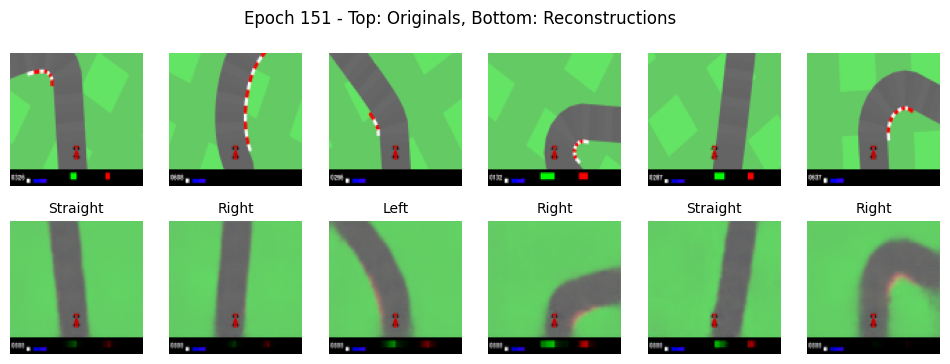

====> Epoch: 152 Average loss: 15265.6181
====> Validation loss: 15292.7592
====> Epoch: 153 Average loss: 15266.9913
====> Validation loss: 15290.3713
====> Epoch: 154 Average loss: 15265.6759
====> Validation loss: 15292.2758
====> Epoch: 155 Average loss: 15264.8750
====> Validation loss: 15287.1580
====> Epoch: 156 Average loss: 15264.0582
====> Validation loss: 15286.0137
====> Epoch: 157 Average loss: 15263.5346
====> Validation loss: 15291.9022
====> Epoch: 158 Average loss: 15263.8245
====> Validation loss: 15288.8412
====> Epoch: 159 Average loss: 15263.2018
====> Validation loss: 15293.8674
====> Epoch: 160 Average loss: 15267.3357
====> Validation loss: 15293.8829
Saved model weights to pre_model_weights/160/vae.pth
====> Epoch: 161 Average loss: 15267.6887
====> Validation loss: 15286.8344


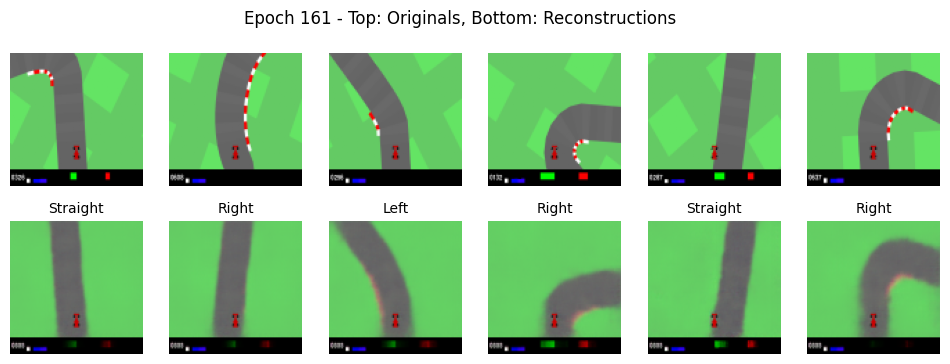

====> Epoch: 162 Average loss: 15265.3459
====> Validation loss: 15291.7102
====> Epoch: 163 Average loss: 15264.7977
====> Validation loss: 15287.3964
====> Epoch: 164 Average loss: 15261.9285
====> Validation loss: 15289.0599
====> Epoch: 165 Average loss: 15263.1796
====> Validation loss: 15290.1809
====> Epoch: 166 Average loss: 15263.1450
====> Validation loss: 15289.7471
====> Epoch: 167 Average loss: 15263.2862
====> Validation loss: 15288.2326
====> Epoch: 168 Average loss: 15263.1990
====> Validation loss: 15288.4438
====> Epoch: 169 Average loss: 15264.4670
====> Validation loss: 15289.3534
====> Epoch: 170 Average loss: 15264.1193
====> Validation loss: 15288.9277
====> Epoch: 171 Average loss: 15263.7179
====> Validation loss: 15298.6859


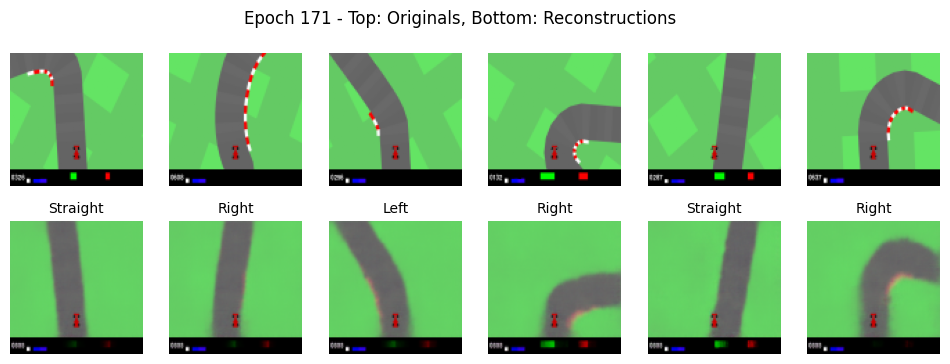

====> Epoch: 172 Average loss: 15263.6764
====> Validation loss: 15292.4156
====> Epoch: 173 Average loss: 15263.5111
====> Validation loss: 15287.8784
====> Epoch: 174 Average loss: 15261.8155
====> Validation loss: 15285.7764
====> Epoch: 175 Average loss: 15261.6091
====> Validation loss: 15286.6764
====> Epoch: 176 Average loss: 15261.5554
====> Validation loss: 15287.0696
====> Epoch: 177 Average loss: 15260.4559
====> Validation loss: 15286.5997
====> Epoch: 178 Average loss: 15263.2604
====> Validation loss: 15294.8254
====> Epoch: 179 Average loss: 15264.0718
====> Validation loss: 15292.2661
====> Epoch: 180 Average loss: 15260.5227
====> Validation loss: 15288.5195
Saved model weights to pre_model_weights/180/vae.pth
====> Epoch: 181 Average loss: 15260.3691
====> Validation loss: 15285.9325


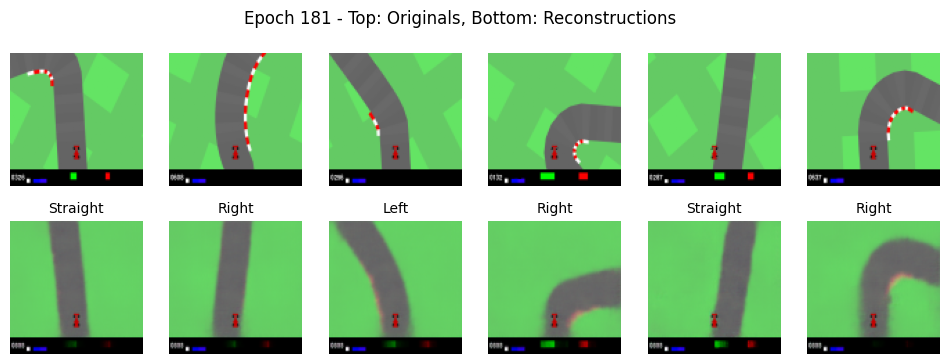

====> Epoch: 182 Average loss: 15262.3683
====> Validation loss: 15289.7605
====> Epoch: 183 Average loss: 15264.0331
====> Validation loss: 15292.6999
====> Epoch: 184 Average loss: 15262.2608
====> Validation loss: 15292.3695
====> Epoch: 185 Average loss: 15261.4273
====> Validation loss: 15288.2727
====> Epoch: 186 Average loss: 15261.4373
====> Validation loss: 15293.2297
====> Epoch: 187 Average loss: 15261.9920
====> Validation loss: 15293.4652
====> Epoch: 188 Average loss: 15259.9750
====> Validation loss: 15288.3840
====> Epoch: 189 Average loss: 15261.0082
====> Validation loss: 15289.9473
====> Epoch: 190 Average loss: 15259.7015
====> Validation loss: 15287.3228
====> Epoch: 191 Average loss: 15259.0716
====> Validation loss: 15290.1160


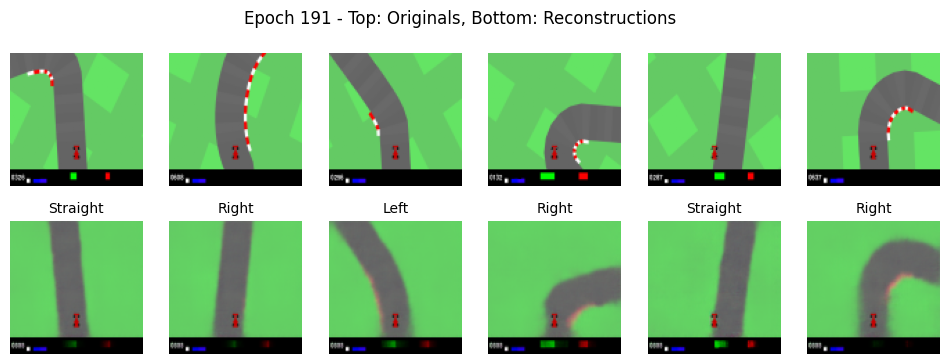

====> Epoch: 192 Average loss: 15258.6618
====> Validation loss: 15289.1872
====> Epoch: 193 Average loss: 15262.4899
====> Validation loss: 15294.6084
====> Epoch: 194 Average loss: 15260.1372
====> Validation loss: 15291.6595
====> Epoch: 195 Average loss: 15259.9396
====> Validation loss: 15291.5414
====> Epoch: 196 Average loss: 15259.2326
====> Validation loss: 15290.7693
====> Epoch: 197 Average loss: 15259.8458
====> Validation loss: 15290.9887
====> Epoch: 198 Average loss: 15258.4636
====> Validation loss: 15293.4048
====> Epoch: 199 Average loss: 15259.8977
====> Validation loss: 15287.4299
====> Epoch: 200 Average loss: 15258.9254
====> Validation loss: 15286.0258
Saved model weights to pre_model_weights/200/vae.pth
Testing the final model:
====> Test loss: 15308.1098


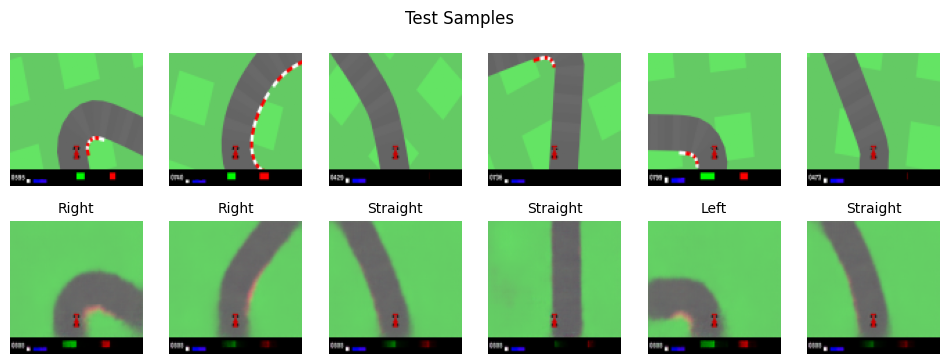

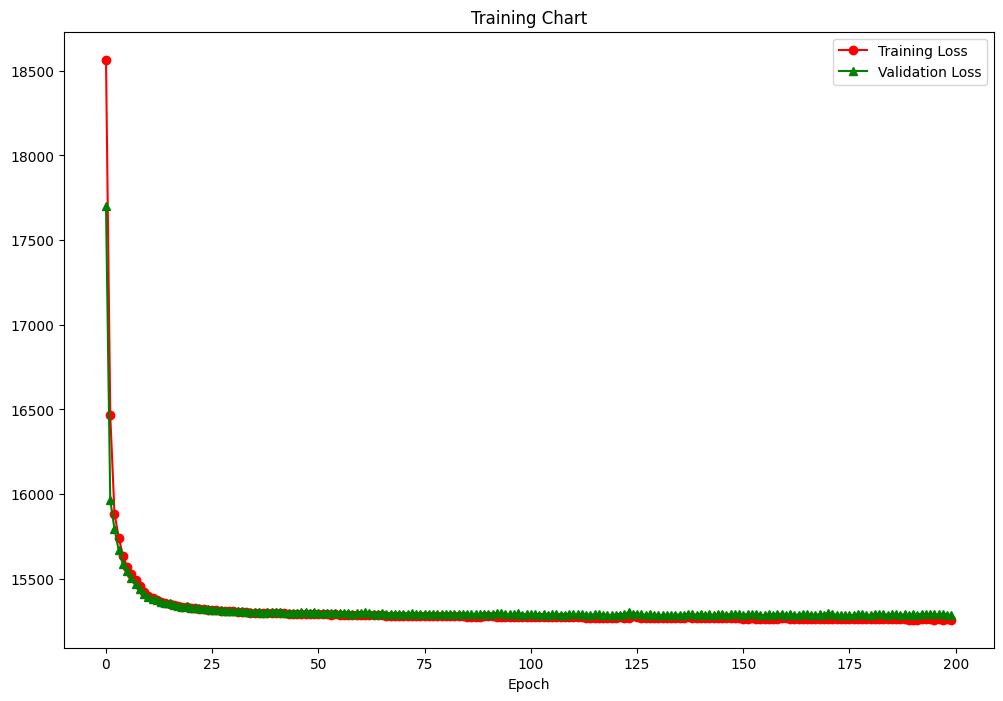

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2  # set latent space dimension
model = VAE(latent_dim=latent_dim).to(device)

leftoff = 0
if "pre_model_weights" in os.listdir(".") and len(os.listdir("pre_model_weights")) > 0:
    saves = os.listdir("pre_model_weights")
    saves.sort()
    model.load_state_dict(torch.load(os.sep.join(("pre_model_weights", saves[-1], "vae.pth"))))
    leftoff = int(saves[-1])
    print("="*50+f"\n|LOADING MODEL WEIGHTS FROM EPOCH {leftoff}|\n"+"="*50)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200

# Ensure pre_model_weights directory exists
os.makedirs("pre_model_weights", exist_ok=True)
losses = []

for epoch in range(1, num_epochs + 1):
    tloss = train_epoch(model, train_loader, optimizer, device, epoch)
    val_display = (epoch-1)%10 == 0
    vloss = validate_epoch(model, val_loader, device, epoch, val_display)
    losses.append((tloss, vloss))

    # Save model weights every 20 epochs
    if epoch % 20 == 0:
        save_dir = os.path.join("pre_model_weights", str(epoch+leftoff))
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"vae.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Saved model weights to {save_path}")

print("Testing the final model:")
test_model(model, test_loader, device)

plt.style.use("tableau-colorblind10")
fig, ax = plt.subplots(figsize=(12, 8))
n = len(losses)
x = [x_ + leftoff for x_ in range(n)]
ax.plot(x, [l[0] for l in losses], label="Training Loss", color="red", marker="o")
ax.plot(x, [l[1] for l in losses], label="Validation Loss", color="green", marker="^")
plt.legend()
plt.title("Training Chart")
plt.xlabel("Epoch")
plt.show()

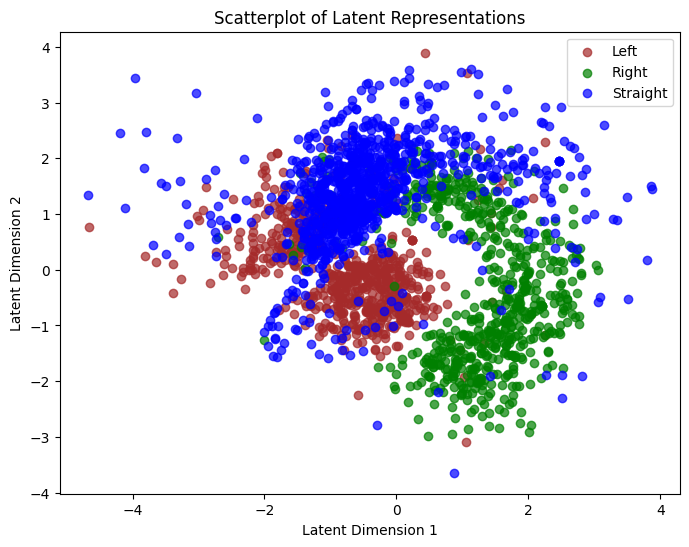

In [21]:
latents = []
labels_list = []
# Define the mapping: left -> 0 (brown), right -> 1 (green), straight -> 2 (blue)
color_map = {'Left': 'brown', 'Right': 'green', 'Straight': 'blue'}

# Iterate over the entire dataset by index.
for idx in range(len(dataset)):
    # Load image tensor.
    image, lbl = dataset[idx]
    label = LABELS[lbl]
    # Expand dims to create a batch of one.
    image = image.unsqueeze(0).to(device)
    # Pass through the encoder to get latent mean.
    with torch.no_grad():
        mu, _ = model.encode(image)
    latents.append(mu.cpu().numpy().flatten())
    labels_list.append(label)

latents = np.array(latents)
colors = [color_map[l] for l in labels_list]

plt.figure(figsize=(8, 6))
for name, color in zip(color_map.keys(), color_map.values()):
    indices = [i for i, l in enumerate(labels_list) if l == name]
    plt.scatter(latents[indices, 0], latents[indices, 1], c=color, label=name, alpha=0.7)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.title("Scatterplot of Latent Representations")
plt.show()

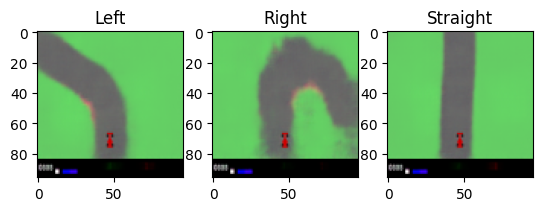

In [22]:
avgs = {}
for name in color_map.keys():
    indices = [i for i, l in enumerate(labels_list) if l == name]
    avgs[name] = np.mean(latents[indices, :], axis=0)

avg_imgs = []
names = []
fig, ax = plt.subplots(1, 3)
for i, (name, mu) in enumerate(zip(avgs.keys(), avgs.values())):
    img = model.decode(torch.tensor(mu).reshape(1, 2).to(device))
    ax[i].imshow(np.transpose(img.detach().cpu().numpy()[0], (1, 2, 0)))
    ax[i].set_title(name)

In [43]:
torch.save(model.state_dict(), 'vae_weights.pth')